In [134]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
from IPython.display import clear_output

In [2]:
!wget https://ocw.mit.edu/ans7870/6/6.006/s08/lecturenotes/files/t8.shakespeare.txt

--2016-10-22 12:41:27--  https://ocw.mit.edu/ans7870/6/6.006/s08/lecturenotes/files/t8.shakespeare.txt
Resolving ocw.mit.edu (ocw.mit.edu)... 104.108.36.226, 2a02:26f0:64:18d::18a8, 2a02:26f0:64:185::18a8
Connecting to ocw.mit.edu (ocw.mit.edu)|104.108.36.226|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5458199 (5.2M) [text/plain]
Saving to: 't8.shakespeare.txt'

100%[======================================>] 5,458,199    954KB/s   in 5.7s   

2016-10-22 12:41:34 (934 KB/s) - 't8.shakespeare.txt' saved [5458199/5458199]



In [22]:
with open('t8.shakespeare.txt') as file:
    raw_lines = [line.replace('\r',' ') for line in file.readlines()]
raw_text = ' '.join(raw_lines[300:-300])

In [236]:
vocab = list(set(raw_text))
trans_dic = {vocab[i]: i for i in range(len(vocab))}
rev_trans_dic = {i: vocab[i] for i in range(len(vocab))}
raw_text_enc = [trans_dic[letter] for letter in raw_text]

define some parameters

In [122]:
text_size = len(raw_text_enc)
vocab_size = len(vocab)
num_neurons = 20
num_steps = 20
batch_size = 4000

In [136]:
text_size // batch_size

1389

function to generate batches of data

In [123]:
def gen_batch(raw_x, batch_size, num_steps):

    if batch_size % num_steps != 0:
        warnings.warn("Warning: batch size is not a multiple of num_steps.")
    
    raw_y = raw_x[1:] + [raw_x[0]]
    
    # partition raw data into batches and stack them vertically in a data matrix
    num_batch = len(raw_x) // batch_size
    data_x = np.zeros([num_batch, batch_size], dtype=np.int32)
    data_y = np.zeros([num_batch, batch_size], dtype=np.int32)
    
    for i in range(num_batch):
        data_x[i] = raw_x[batch_size * i:batch_size * (i + 1)]
        data_y[i] = raw_y[batch_size * i:batch_size * (i + 1)]
    
    # further divide batch partitions into num_steps for truncated backprop
    batch_lines = batch_size // num_steps

    for i in range(num_batch):
        x = np.zeros([batch_lines,num_steps],dtype=np.int32)
        y = np.zeros([batch_lines,num_steps],dtype=np.int32)
        for n in range(batch_lines):
            x[n,:] = data_x[i, n * num_steps:(n + 1) * num_steps]
            y[n,:] = data_y[i, n * num_steps:(n + 1) * num_steps]
        yield (x, y)

In [124]:
def gen_epochs(raw_data, num_epochs, batch_size, num_steps):
    for i in range(num_epochs):
        yield gen_batch(raw_data,batch_size,num_steps)

### define the graph

In [175]:
tf.reset_default_graph()

input layer:

In [176]:
x = tf.placeholder(tf.int32, [None, num_steps])
y = tf.placeholder(tf.int32, [None, num_steps])
init_state = tf.placeholder(tf.float32,[None, num_neurons])

#resulting tensor is of rank batch_size // num_steps x num_steps x vocab_size
x_one_hot = tf.one_hot(x, vocab_size)

hidden layer:

In [177]:
cell = tf.nn.rnn_cell.BasicRNNCell(num_neurons)
rnn_output, final_state = tf.nn.dynamic_rnn(cell, x_one_hot, initial_state=init_state, dtype=tf.float32)

output layer:

In [178]:
weight = tf.Variable(tf.truncated_normal([num_neurons, vocab_size], stddev=0.1))
bias = tf.Variable(tf.constant(0.1, shape=[vocab_size]))

output = tf.reshape(rnn_output, [-1, num_neurons])
logits = tf.matmul(output, weight) + bias
prediction = tf.nn.softmax(logits)
prediction = tf.reshape(prediction, [-1, num_steps, vocab_size])

loss function:

In [180]:
target = tf.reshape(y,[-1])
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits,target))

training:

In [181]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
trainOp = optimizer.minimize(loss)

In [205]:
init_vars = tf.initialize_all_variables()
trainHist = []

sess = tf.Session()
sess.run(init_vars)
for epoch in gen_epochs(raw_text_enc[:],1,batch_size,num_steps):
    training_state = np.zeros((batch_size // num_steps, num_neurons))
    for i, batch in enumerate(epoch):
        lossVal, training_state, _ = sess.run([loss, final_state, trainOp], feed_dict={x: batch[0], y: batch[1],init_state: training_state})
        trainHist.append(lossVal)

        if i % 100 == 0:
            clear_output()
            print(i, lossVal)

(1300, 2.1346393)


forward-feed:

In [242]:
prev = np.random.choice(vocab_size,num_steps).astype(np.float32).reshape(1,num_steps)
last_state = np.zeros((1, num_neurons),dtype=np.float32)

digital_shakespeare = []

for i in range(1000):
    pred, last_state = sess.run([prediction,final_state],feed_dict={x: prev, init_state: last_state})
    prev = np.argmax(pred,axis=2)
    digital_shakespeare += [rev_trans_dic[i] for i in prev.flatten().tolist()]

In [243]:
"".join(digital_shakespeare)

'EO N .E\nE  er. eeoEa\nNIEL L R An  I  r r E S.IOSOLNdt  t otebnIo O. .IE  t h f reot tn I\nOSITh eto oat thot  RE Eeh hrtfr theu t oRLx eteeheethe rth f\nIitnhr er  ertoieoo  n   etnet n  rn rdt ot Tn    tot e to etf thot T h htlth trhetheu th ete eoeohee herrthe  hrtntdre  ter e ert eeh h e t hr tntn  tl etet th ee hoe t he  hrhthe   teudth ert eee ert  hrr  eale tl  tre t eeet nrl the  hosth     toee he t eu  ea    h d terth  tt nrt   eto hr  ea h  oeea  n rtee  nrtet f  rt otihr t oeerhto  e tf neeth f   e rt nthe o   eao   ntoito e tft  nrdt  o  n rtrtheht oe ht ft otihehere tf te tohtf nerer  the hrth e  to e  t he teeheo t h trt h erthr errth etheetet e eetn e ealher  rhtrtn   trtnrl   t oe eh t  heeeee   h f treth  er  rrt  eto hos ea n t oeea n nteu trrtoth f  rtotoerrtheeeuheto  e uhrr e er  re  rt nttteetntn t o t ehto   r     th fth  e rt  ot    he ohe  ntoit f t   ertfe t o  n to h   n  e th ft oth tet  ot xthe oh f ethr t f te e tfeto  heeth o hrtnthea rt er  eafteeh he 

In [235]:
res = np.argmax(pred,axis=2)
res.flatten().shape

(20,)

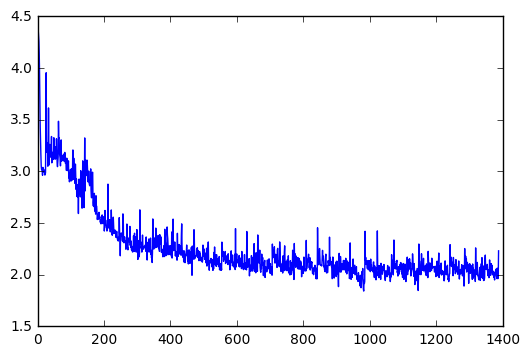

In [163]:
plt.plot(trainHist)

# Hyperparams:

In [140]:
grid = []
for learnRate in [0.0001,0.001,0.01,0.1]:

    optimizer = tf.train.AdamOptimizer(learning_rate=learnRate)
    trainOp = optimizer.minimize(loss)

    init_vars = tf.initialize_all_variables()
    trainHist = []
    with tf.Session() as sess:
        sess.run(init_vars)
        for epoch in gen_epochs(raw_text_enc[:],1,batch_size,num_steps):
            for i, batch in enumerate(epoch):
                lossVal, _ = sess.run([loss,trainOp],feed_dict={x: batch[0], y: batch[1]})
                trainHist.append(lossVal)

                if i % 100 == 0:
                    clear_output()
                    print(learnRate, i, lossVal)
    
    grid.append(trainHist)

(0.1, 1300, 2.0869632)


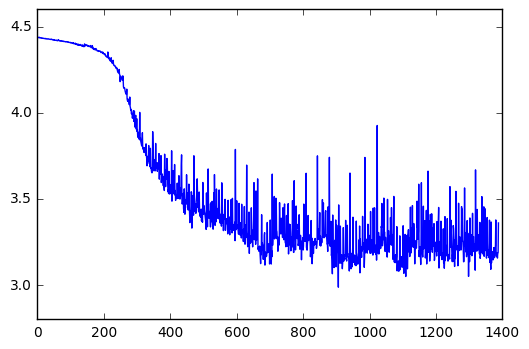

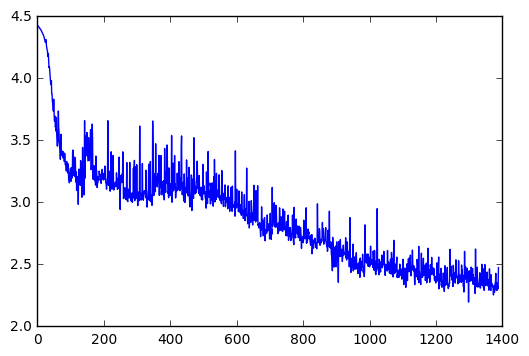

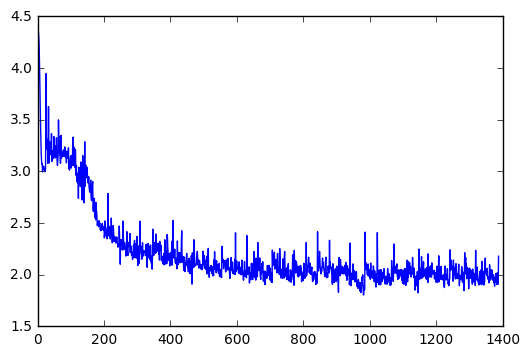

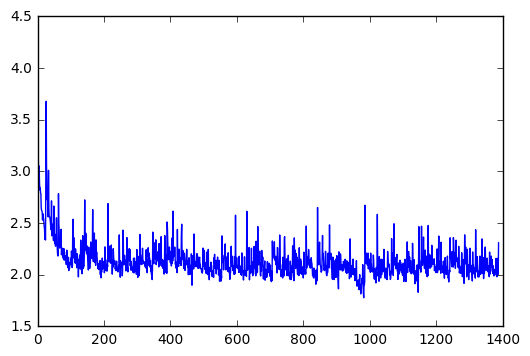

In [142]:
for i in range(4):
    plt.plot(grid[i])
    plt.show()